# CS294-082 Project Notebook
Referred to [Gerald's Chapter 9](https://piazza.com/redirect/s3?bucket=uploads&prefix=paste%2Fjeqdgp7ec8fv4%2Fbb8d09923f28f8df1326688d66f267909167aa329fce3b0f33616c54e562338e%2FInformation_View_on_Data_Science.pdf) for dataset MEC and progression curve algorithms (Algorithm 1 & Algorithm 2).

In [9]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(12,8)})

In [2]:
# setup direcotry path on local machine
directory_path = "C:\\Users\\micha\\Desktop\\Fall 2021\\EECS 294-082"
os.chdir(directory_path)

## Utils for calculating the dataset MEC

In [3]:
feature_cols = 256
# input: dataframe contains labels and thresholds, sorted by descending thresholds
# output: a dictionary with key as labels, value as sums of feature values
# def: iterate through the labels, increment corresponding label's threshold by 1 whenever the label changes
def generate_MEC_dict(df):
    current_class = -1
    # generate an empty dictionary from df, with default value as 0
    mec_dict = dict.fromkeys(df['label'], 0)
    # increment dict value by 1 whenever the class changes
    for index, row in df.iterrows():
        if(row['label'] != current_class):
            mec_dict[row['label']] += 1
            current_class = row['label']
    return mec_dict

# input: dataframe with labels, thresholds, and label occurrences
# output: print out the dataset MEC
# using the formula to calculate MEC: sum(1/pi * log_2(threshold+1)), for all i classes
def calculate_MEC(df):
    mec = 0
    total = df['counts'].sum()
    for index, row in df.iterrows():
        percentage = row['counts'] / total
        mec += (1 / percentage) * np.log2(row['threshold'] + 1)
    print('The total MEC of the dataset is: ', mec)
    return mec

# input: dataframe with all the features, labels (labels in the last column)
# output: print out the dataset MEC
# dataframe manipulation, and calculate the MEC of the dataset
def calc_dataset_MEC(df):
    # extract the preceding feature columns
    cols = df.columns[:feature_cols]
    # added a new column of the sum of features for each instance
    df['sums'] = df[cols].sum(axis=1)
    # count the occurrence for each lable
    df['counts'] = df.groupby(['label'])['label'].transform('count')
    count_df = df[['label', 'counts']]
    count_df = count_df.drop_duplicates(subset=['label']).reset_index(drop=True)
    # generate the mec df with descending feature sums 
    # last three columns label, sum, count
    # sort by descending feature value sums
    mec_df = df.sort_values('sums', ascending=False).iloc[:, -3:].reset_index(drop=True)
    # produce the threshold dict for calculating MEC
    mec_dict = generate_MEC_dict(mec_df)
    # convert the dict into dataframe
    threshold_df = pd.DataFrame(mec_dict.items(), columns=['label', 'threshold'])
    threshold_df = threshold_df.merge(count_df, on='label').sort_values(by=['counts'], ascending=False).reset_index(drop=True)
    return calculate_MEC(threshold_df)

## MEC of the original dataset

In [4]:
data_with_label_df = pd.read_csv("transformer_data_with_label.csv")
calc_dataset_MEC(data_with_label_df);

The total MEC of the dataset is:  75522.1713331209


## MEC of the balanced dataset 
### Only contains classes with more than 100 instances

In [5]:
balanced_df = pd.read_csv('balanced_df_with_default_labels.csv')
calc_dataset_MEC(balanced_df);

The total MEC of the dataset is:  3862.3580275664503


## Capacity Progression Curve

In [6]:
# input: dataframe with features and label (same as mec df)
# output: dataframe containing mec values for different % of training data
# algorithm 2: sample training data from 5 to 100 percent (step 5) and generate the df 
def progression_curve(df):
    pcurve_df = pd.DataFrame(columns = ['size', 'mec'])
    sizes = [i for i in np.arange(5,101,5)]
#     sizes = [5,10,20,40,80,100]
    # sample the dataset and calculate its MEC
    for size in sizes:
        current_df = df.sample(frac=size/100)
        current_mec = calc_dataset_MEC(current_df)
        pcurve_df = pcurve_df.append({'size' : size, 'mec' : current_mec},
               ignore_index = True)
    return pcurve_df
pcurve_df = progression_curve(balanced_df)
# pcurve_df = progression_curve(data_with_label_df)
pcurve_df

The total MEC of the dataset is:  1701.2977869002884
The total MEC of the dataset is:  2046.1509712073027
The total MEC of the dataset is:  2420.4117956268324
The total MEC of the dataset is:  2630.263024111816
The total MEC of the dataset is:  2749.826434176407
The total MEC of the dataset is:  2942.3372670115928
The total MEC of the dataset is:  2990.9849482206373
The total MEC of the dataset is:  3120.907554758489
The total MEC of the dataset is:  3210.770747760075
The total MEC of the dataset is:  3308.826436046965
The total MEC of the dataset is:  3355.1509855286586
The total MEC of the dataset is:  3455.6595900220173
The total MEC of the dataset is:  3514.8098448675914
The total MEC of the dataset is:  3587.8044633846393
The total MEC of the dataset is:  3619.581902722955
The total MEC of the dataset is:  3695.225541563681
The total MEC of the dataset is:  3713.958454565457
The total MEC of the dataset is:  3768.9378899503713
The total MEC of the dataset is:  3824.9787166900824
T

,size,mec
0,5.0,1701.297787
1,10.0,2046.150971
2,15.0,2420.411796
3,20.0,2630.263024
4,25.0,2749.826434
5,30.0,2942.337267
6,35.0,2990.984948
7,40.0,3120.907555
8,45.0,3210.770748
9,50.0,3308.826436


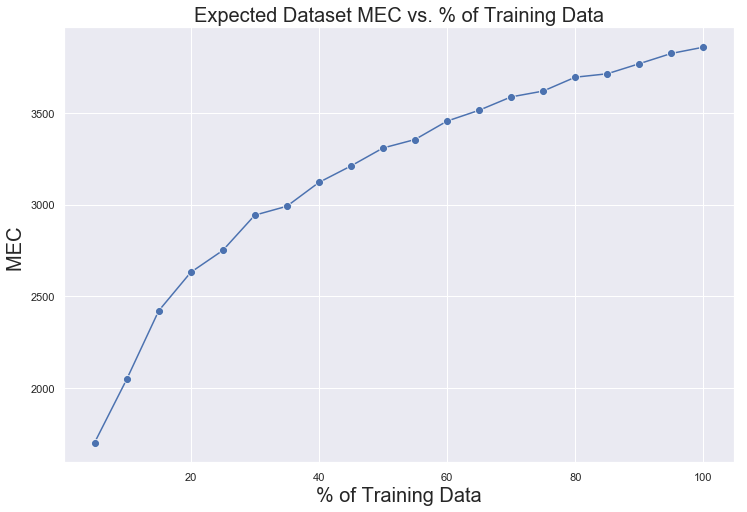

In [10]:
p = sns.lineplot(x='size', y='mec', data=pcurve_df, marker='o', markersize=8)
p.set_xlabel("% of Training Data", fontsize = 20)
p.set_ylabel("MEC ", fontsize = 20)
p.set_title("Expected Dataset MEC vs. % of Training Data", size = 20);

## Generate balanced dataset
### classes with instances >= 100 (for brainome)

In [8]:
balance_df = data_with_label_df.groupby('label').filter(lambda x: len(x) > 100)
balance_df = balance_df.reset_index()
balance_df.to_csv("balanced_df.csv")
balance_df

,index,0,1,2,3,4,5,6,7,8,...,249,250,251,252,253,254,255,label,sums,counts
0,0,0,0,0,10,4,0,0,1,8,...,0,0,0,0,0,0,0,77,267,251
1,1,0,0,0,12,1,8,0,2,10,...,0,0,0,0,0,0,0,77,325,251
2,2,0,0,0,10,11,2,0,2,10,...,0,0,0,0,0,0,0,77,240,251
3,3,0,0,0,10,15,0,0,2,9,...,0,0,0,0,0,0,0,77,236,251
4,4,0,0,0,10,0,9,0,2,10,...,0,0,0,0,0,0,0,77,257,251
5,5,0,0,0,10,0,7,0,1,8,...,0,0,0,0,0,0,0,77,290,251
6,6,0,0,0,9,11,0,0,2,10,...,0,0,0,0,0,0,0,77,279,251
7,7,0,0,0,9,0,1,0,2,10,...,0,0,0,0,0,0,0,77,278,251
8,8,0,0,0,9,0,0,0,1,9,...,0,0,0,0,0,0,0,77,267,251
9,9,0,0,0,8,0,0,0,2,9,...,0,0,0,0,0,0,0,77,255,251
